## Градиентный бустинг и бэггинг

Сравним, как ведут себя бустинг и бэггинг с ростом числа базовых алгоритмов.

В случае бэггинга все базовые алгоритмы настраиваются на различные выборки из одного и того же распределения на $\mathbb{X} \times \mathbb{Y}$. При этом некоторые из них могут оказаться переобученными, однако усреднение позволяет ослабить этот эффект (объясняется тем, что для некоррелированных алгоритмов разброс композиции оказывается в $N$ раз меньше разброса отдельных алгоритмов, т.е. много деревьев с меньшей вероятностью настроятся на некоторый нетипичный объект по сравнению с одним деревом). Если $N$ достаточно велико, то последующие добавления новых алгоритмов уже не позволят улучшить качество модели.

В случае же бустинга каждый алгоритм настраивается на ошибки всех предыдущих, это позволяет на каждом шаге настраиваться на исходное распределение все точнее и точнее. Однако при достаточно большом $N$ это является источником переобучения, поскольку последующие добавления новых алгоритмов будут продолжать настраиваться на обучающую выборку, уменьшая ошибку на ней, при этом уменьшая обобщающую способность итоговой композиции.

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

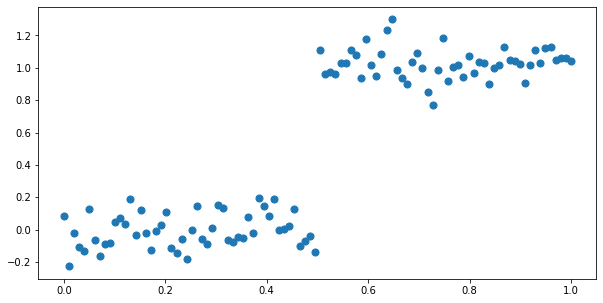

In [ ]:
X_train = np.linspace(0, 1, 100)
X_test = np.linspace(0, 1, 1000)

@np.vectorize
def target(x):
    return x > 0.5

Y_train = target(X_train) + np.random.randn(*X_train.shape) * 0.1

plt.figure(figsize = (10, 5))
plt.scatter(X_train, Y_train, s=50)

all methods with warm_start

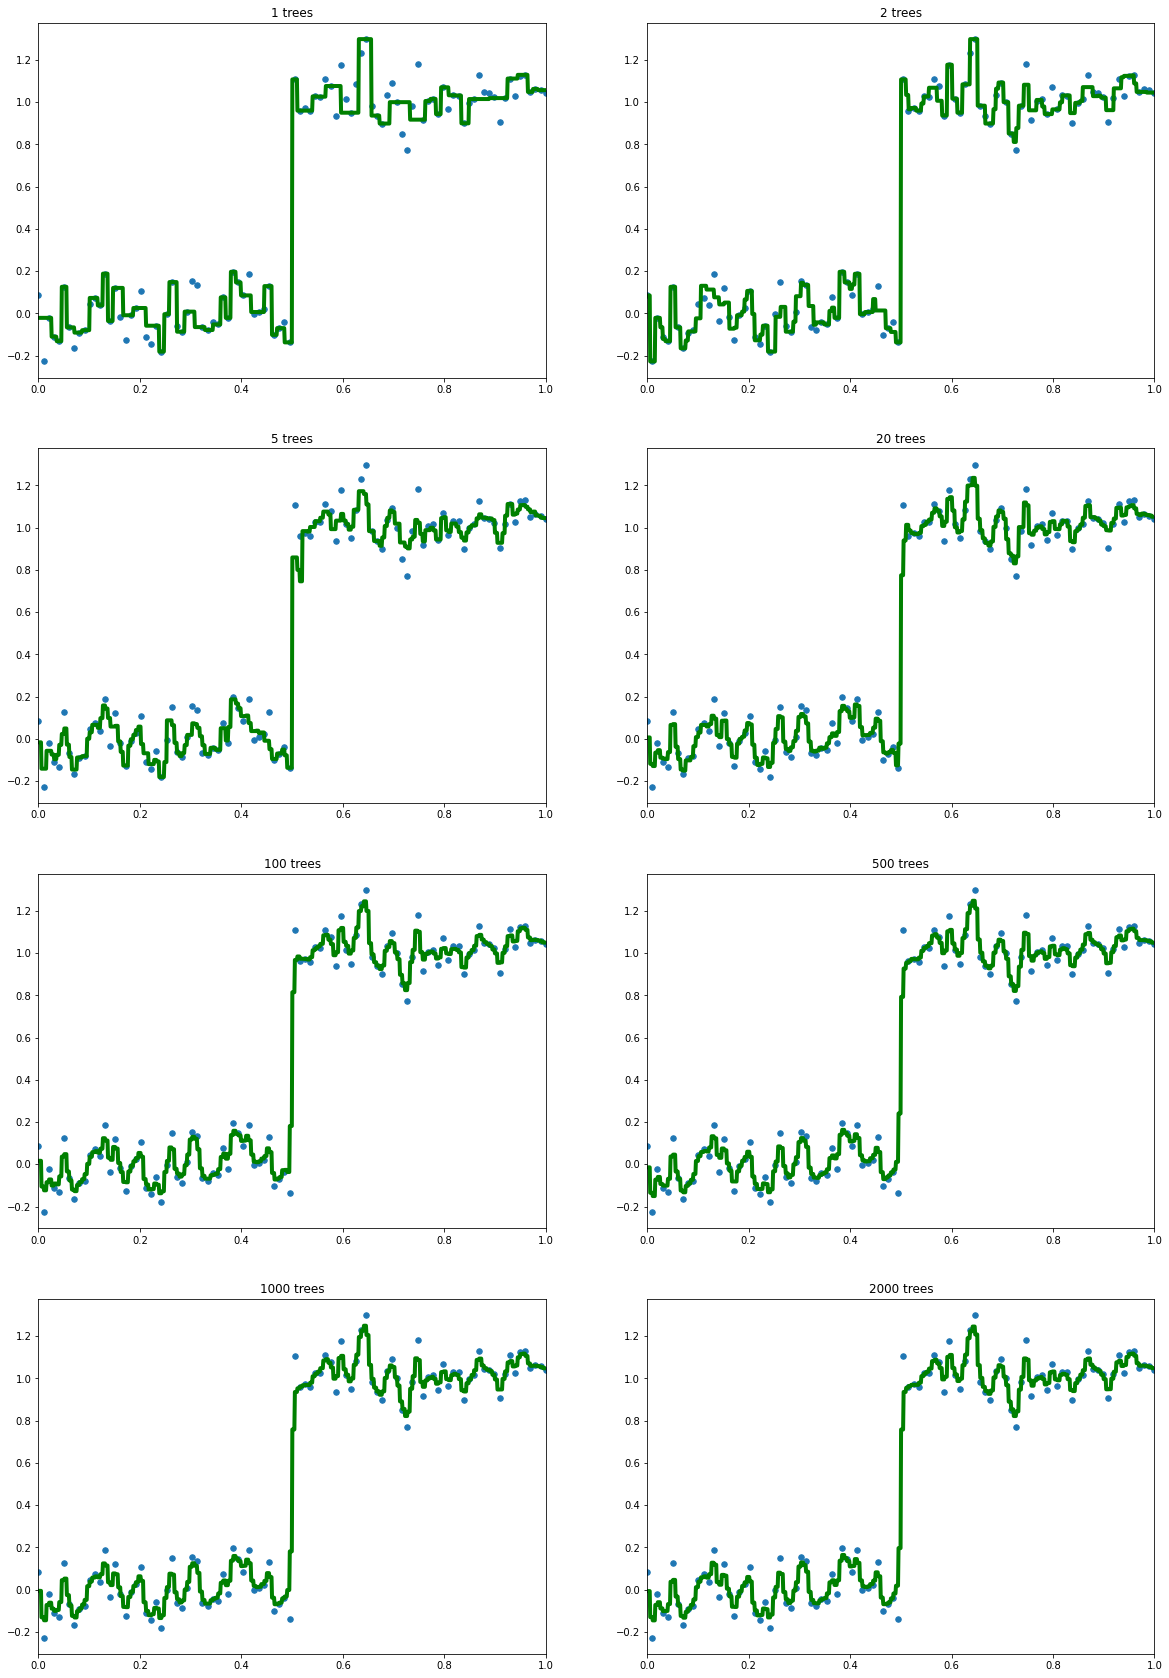

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor

reg = BaggingRegressor(DecisionTreeRegressor())
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

Можно заметить, что с некоторого момента итоговая функция перестает меняться с ростом количества деревьев.

Теперь проделаем то же самое для градинентного бустинга.

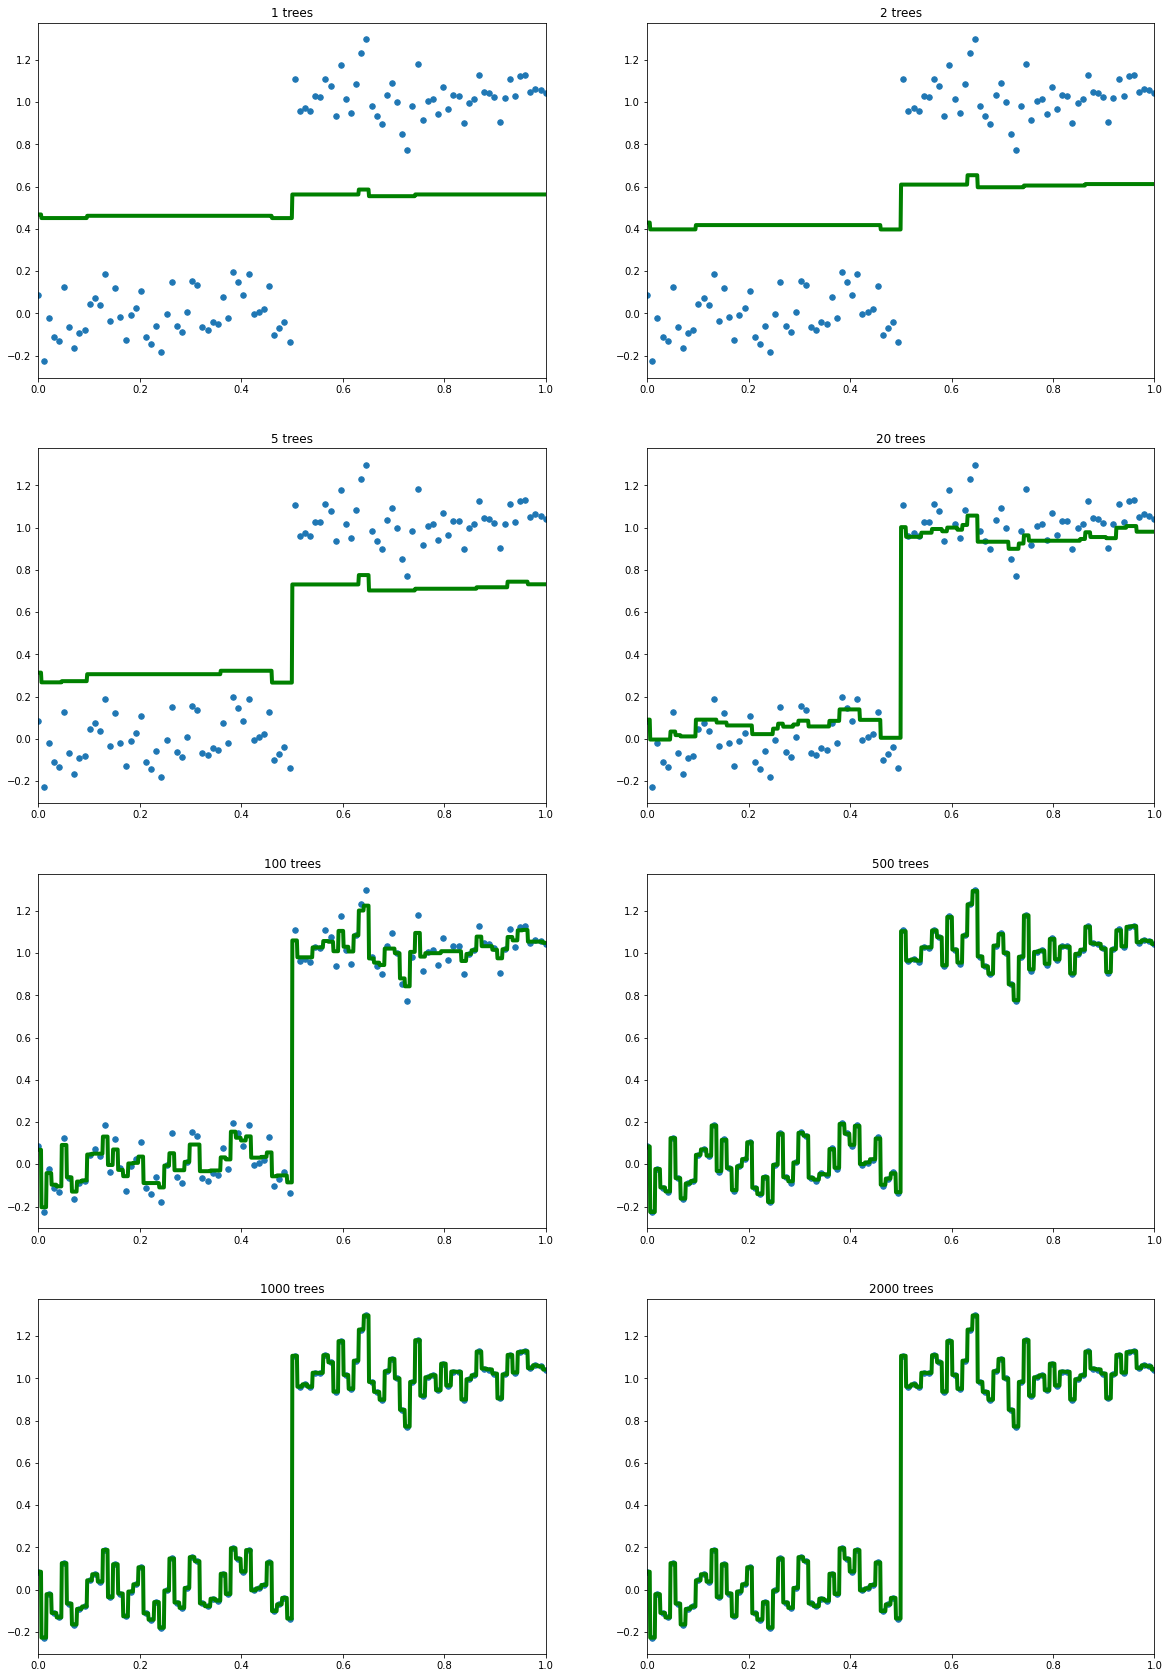

In [ ]:
reg = GradientBoostingRegressor()
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

Градиентный бустинг довольно быстро построил истинную зависимость, после чего начал настраиваться уже на конкретные объекты обучающей выборки, из-за чего сильно переобучился.


Бороться с этой проблемой можно с помощью выбора очень простого базового алгоритма или
же искусственным снижением веса новых алгоритмов при помощи шага $\eta$:
$$a_N(x) = \sum_{n=0}^N \eta \gamma_N b_n(x).$$

Такая поправка замедляет обучение по сравнению с бэггингом, но зато позволяет получить менее переобученный алгоритм. Тем не менее, важно понимать, что переобучение всё равно будет иметь место при обучении сколь угодно большого количества базовых алгоритмов для фиксированного $\eta$.

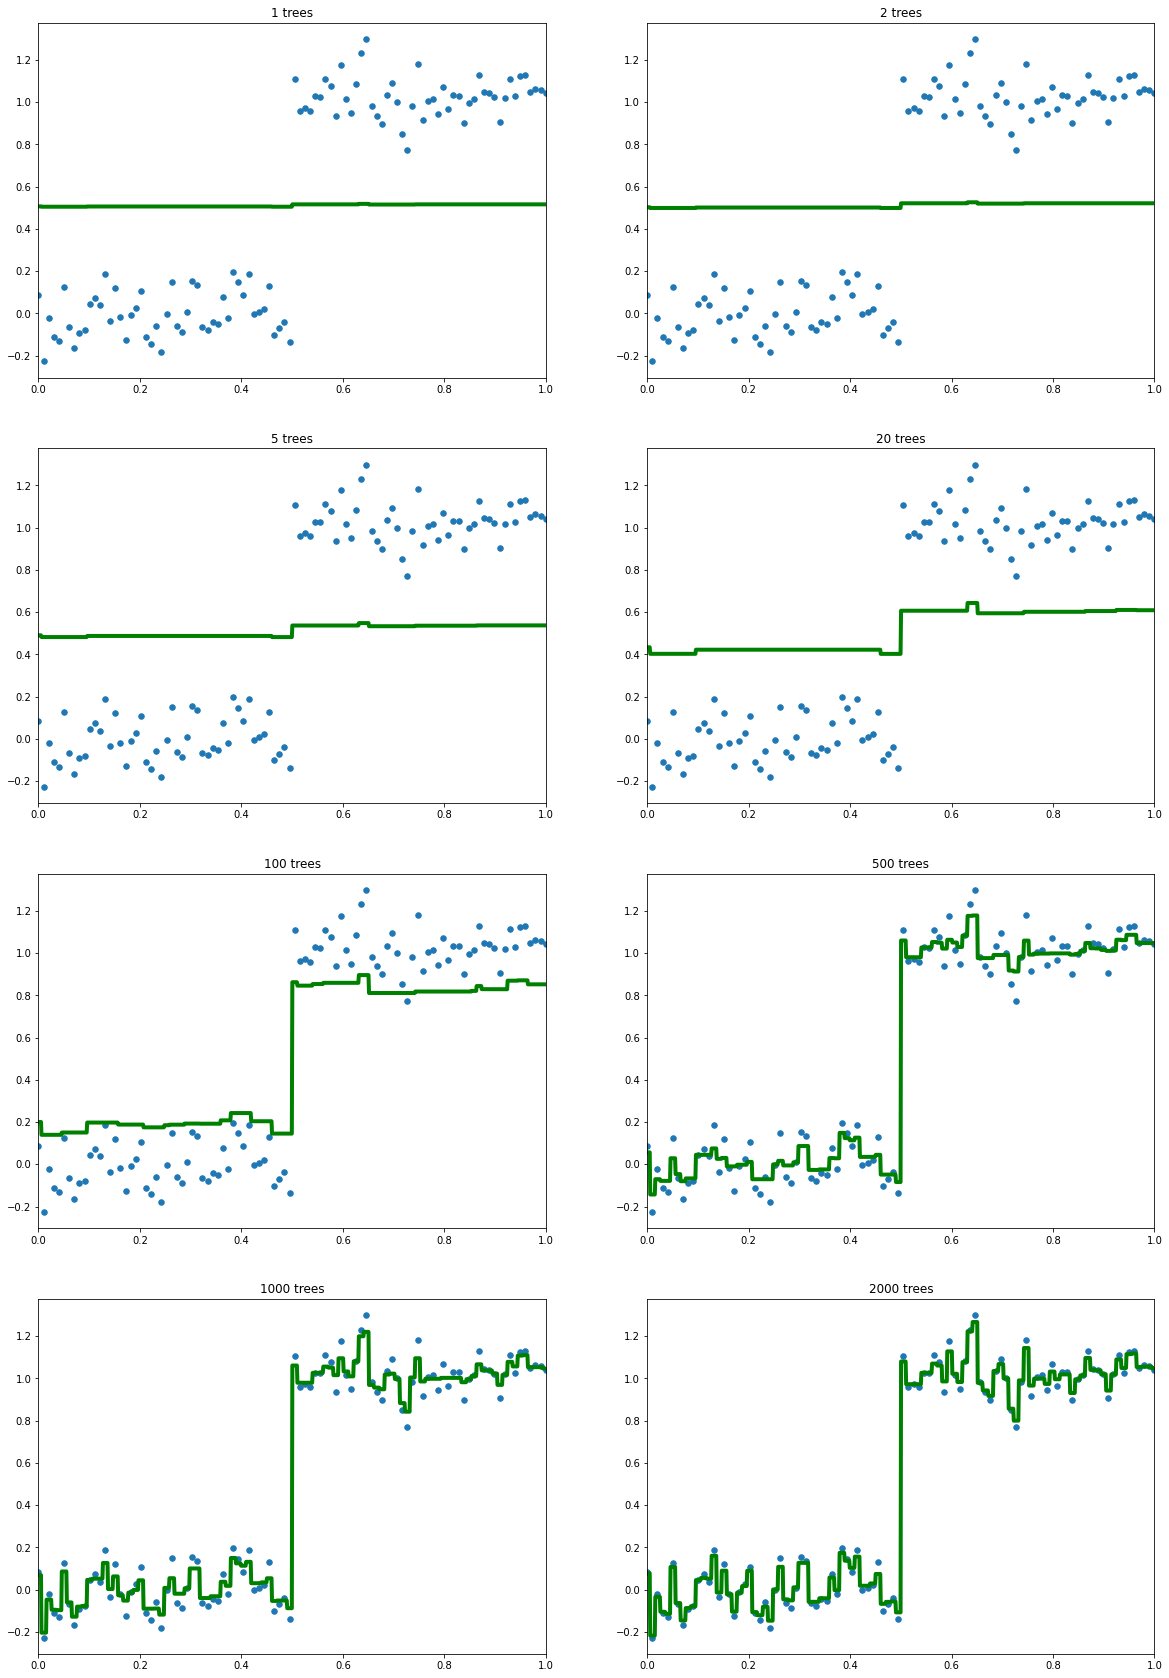

In [ ]:
reg = GradientBoostingRegressor(learning_rate=1e-2)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

Теперь проверим описанный выше эффект на реальных данных.

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

ds = datasets.load_diabetes()
X = ds.data
Y = ds.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,
                                                    train_size=0.5)

MAX_ESTIMATORS = 300

gbclf = BaggingRegressor(DecisionTreeRegressor())
err_train_bag = []
err_test_bag = []
for i in range(1, MAX_ESTIMATORS+1):
    gbclf.n_estimators = i
    gbclf.fit(X_train, Y_train)
    err_train_bag.append(1 - gbclf.score(X_train, Y_train))
    err_test_bag.append(1 - gbclf.score(X_test, Y_test))
    
gbclf = GradientBoostingRegressor(learning_rate=1e-2)
err_train_gb = []
err_test_gb = []
for i in range(1, MAX_ESTIMATORS+1):
    gbclf.n_estimators = i
    gbclf.fit(X_train, Y_train)
    err_train_gb.append(1 - gbclf.score(X_train, Y_train))
    err_test_gb.append(1 - gbclf.score(X_test, Y_test))
    


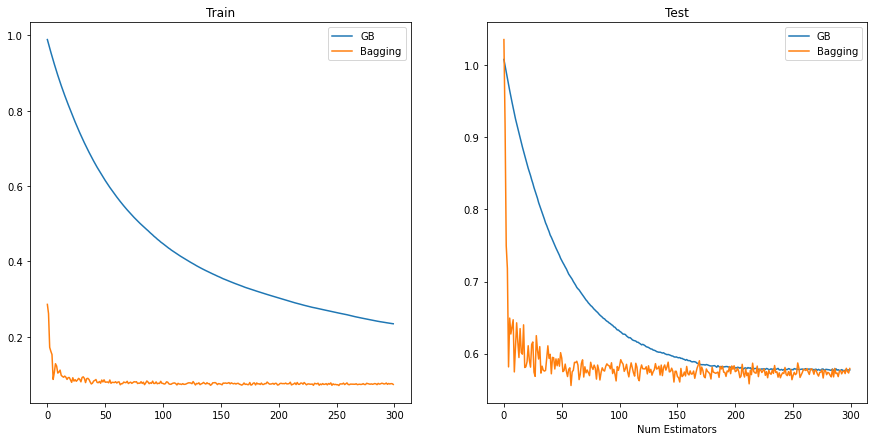

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(err_train_gb, label='GB')
plt.plot(err_train_bag, label='Bagging')
plt.legend()
plt.title('Train')
plt.subplot(1, 2, 2)
plt.plot(err_test_gb, label='GB')
plt.plot(err_test_bag, label='Bagging')
plt.legend()
plt.title('Test')
plt.xlabel('Num Estimators')
plt.gcf().set_size_inches(15,7)

## Дополнительный пример

Имеем задачу регрессии на одномерной выборке $X = \{ (x_i, y_i)\}_{i=1}^l,$ при этом истинная зависимость целевой переменной является линейной: $y(x) = ax + \varepsilon, \, \varepsilon \sim p(\varepsilon) = \mathcal{N} (0, \sigma^2).$ Допустим, не зная этого, вы обучили на выборке линейную регрессию и решающее дерево с функционалом MSE, и вам известно, что модели не переобучились. После этого вы получили новые данные и построили на них прогнозы обеих моделей, и оказалось, что для решающего дерева значение функционала ошибки на новых данных оказалось радикально выше, чем для линейной регрессии. Чем это может быть вызвано?


Допустим, обучающая выборка была получена из отрезка $[0; 10],$ обучим соответствующие модели и построим прогнозы для этого отрезка:

In [ ]:
from numpy.random import rand, randn

set_size = 100
lin_coef = 3
sigma = 1

X_train = (rand(set_size)*10).reshape(-1, 1)
Y_train = 2*X_train+sigma*
plt.figure(figsize=(12, 7))
plt.scatter(X_train, Y_train)

SyntaxError: ignored

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# Train models

In [ ]:
from numpy.random import rand, randn

grid = np.arange(-1, 12, 0.1).reshape(-1, 1)

plt.figure(figsize=(12, 7))
plt.scatter(X_train, Y_train)
plt.plot(grid, lin_coef * grid, 'magenta')
plt.plot(grid, lr.predict(grid), 'red',)
plt.plot(grid, tree.predict(grid), 'green')
plt.xlim([-1, 11])
plt.legend(['Ground truth', 'Linear regression', 'Decision tree'], loc=0)
print ('LR train MSE = ', mean_squared_error(Y_train, lr.predict(X_train)))
print ('DT train MSE = ', mean_squared_error(Y_train, tree.predict(X_train)))

Предположим, что новые данные были получены из другой области пространства ответов, например, из отрезка $[20; 30].$ В этом случае предсказания линейной регрессии окажутся гораздо ближе к правде, что отразится и на значении функционала ошибки:

In [ ]:
from numpy.random import rand, randn

grid = np.arange(-1, 32, 0.1).reshape(-1, 1)

X_test = 
Y_test = 
plt.figure(figsize=(12, 7))
plt.scatter(X_train, Y_train, c='blue')
plt.scatter(X_test, Y_test, c='red')

plt.plot(grid, lin_coef * grid, 'magenta')
plt.plot(grid, lr.predict(grid), 'red',)
plt.plot(grid, tree.predict(grid), 'green')
plt.xlim([-1, 31])
plt.legend(['Ground truth', 'Linear regression', 'Decision tree'], loc=0)
print ('LR test MSE = ', mean_squared_error(Y_test, lr.predict(X_test)))
print ('DT test MSE = ', mean_squared_error(Y_test, tree.predict(X_test)))

 
деревья (а потому и композиции над ними, в т.ч. градиентный бустинг) непригодны для экстраполяции функций.

В качестве решения этой проблемы в некоторых случаях можно использовать [нормализацию](http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-normalization).

[Ссылка на ту самую визуализацию](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) градиентного бустинга для решающих деревьев различной глубины